In [1]:
#%pip install scikit-image
#%pip install ipywidgets 

In [ ]:
# scikit-image is used for image processing:
#from skimage import data, io
#import skimage.feature
##import skimage.viewer
#import skimage

# NOTE: CP is an API for the NIST database used for the water Equation of State:
#from CoolProp.CoolProp import PropsSI

# Imports and physical parameters
#%matplotlib notebook


# Local library
from hyperct import *
from ddgclib._sphere import *
from ddgclib._sessile import *
from ddgclib._capillary_rise_flow import * #plot_surface#, curvature
from ddgclib._plotting import plot_polyscope
#from ddgclib.curvatures import plot_surface, curvature

# Equation of state for water droplet:
def eos(P=101.325, T=298.15):
    # P in kPa T in K
    return # PropsSI('D','T|liquid',298.15,'P',101.325,'Water') # density kg /m3

# Surface tension of water gamma(T):
def IAPWS(T=298.15):
    T_C = 647.096  # K, critical temperature
    return 235.8e-3 * (1 -(T/T_C))**1.256 * (1 - 0.625*(1 - (T/T_C)))  # N/m

# Local compression (approx. Hooke's law)
def local_compressive_forces(v, r):
    # Compute the distance of vertex from great sphere centre:
    gsc = -R * np.sin(theta_p) # great sphere centre
   # gsc = +2.3830646612262073e-05 -R * np.sin(theta_p) # great sphere centre
   # gsc = +3e-05 -R * np.sin(theta_p) # great sphere centre
   # gsc = +3.5e-05 -R * np.sin(theta_p) # great sphere centre
   # gsc = +4.5e-05 -R * np.sin(theta_p) # great sphere centre
    if 0:
        N_f0 = np.array(
            #[0.0, 0.0, R * np.sin(theta_p)]) - v.x_a  # First approximation
            [0.0, 0.0, gsc]) - v.x_a  # First approximation
    if 1:
       N_f0 = v.x_a - np.array([0.0, 0.0, gsc])
       #N_f0 = v.x_a - np.array([0.0, 0.0, -(R-R * np.sin(theta_p))])
    print(f' N_f0 = {N_f0}')
    print(f' np.linalg.norm(N_f0) = {np.linalg.norm(N_f0)}')
    # Compute the norm:
    d = np.linalg.norm(N_f0)
    print(f' d = {d}')
    print(f' R = {R}')
    #@print(f' r = {r}')
    if d < R:
        N_f0 = normalized(N_f0)[0]
        #return N_f0 * (r - d)
        #return N_f0 * (R - d)
        return N_f0 * (R - d)
    else:
        return np.array([0.0, 0.0, 0.0])

def mean_flow(HC, bV, params, tau, print_out=False, fix_xy=False, pinnned_line=False):
    (gamma, rho, g, r, theta_p, K_f, h) = params
    if print_out:
        print('.')
        
    ######################################3
    # new height code
    V_xa = []
    for v in HC.V:
        V_xa.append(v.x_a)
    
    V_xa = np.array(V_xa)
    height_max = np.max(V_xa[2])
    #height_bubble_init 
    ######################################3
    
    # Compute interior curvatures
    #(HNda_v_cache, K_H_cache, C_ijk_v_cache, HN_i, HNdA_ij_dot_hnda_i,
    # K_H_2, HNdA_i_Cij) = int_curvatures(HC, bV, r, theta_p, printout=False)
    (HN_i, C_ij, K_H_i, HNdA_i_Cij, Theta_i,
            HNdA_i_cache, HN_i_cache, C_ij_cache, K_H_i_cache, HNdA_i_Cij_cache,
            Theta_i_cache) = HC_curvatures_sessile(HC, bV, r, theta_p, printout=0)

    # if bV is None:
    #bV = HC.boundary()  #TODO: Check it again it is not working properly
    # Move boundary vertices:
    bV_new = set()
    print(f'bV = {bV}')
    for v in HC.V:
        if print_out:
            print(f'.')
            print(f'v.x = {v.x}')
            if v.x[0] == 0.0 and v.x[1] == 0.0:
                print(f'='*10)

        print(f'bV = {bV}')
        # Compute boundary movements
        # Note: boundaries is fixed for now, this is legacy:
        if v in bV:
            rati = (np.pi - np.array(Theta_i) / 2 * np.pi)
            #TODO: THis is not the actual sector ration (wrong angle)
            # rati = np.array(Theta_i) / (2 * np.pi)
            # print(f' rati = 2 * np.pi /np.array(Theta_i)= { rati}')
            print('-'*10)
            print('Boundary vertex:')
            print('-'*10)

            if 0:
                #TODO: len(bV) is sector fraction
                H_K = HNda_v_cache[v.x] * np.array([0, 0, -1]) * len(bV)
                print(f'K_H in bV = {H_K }')

                K_H = ((np.sum(H_K) / 2.0) / C_ijk_v_cache[v.x] ) ** 2
                K_H = ((np.sum(H_K) / 2.0)  ) ** 2
                print(f'K_H in bV = {K_H}')
                print(f'K_H - K_f in bV = {K_H - K_f}')

            K_H_dA = K_H_i_cache[v.x] * np.sum(C_ij_cache[v.x])

            #TODO: Adjust for other geometric approximations:
            l_a = 2 * np.pi * r / len(bV)  # arc length

            Xi = 1
            # Gauss-Bonnet: int_M K dA + int_dM kg ds = 2 pi Xi
            # NOTE: Area should be height of spherical cap
            # h = R - r * 4np.tan(theta_p)
            # Approximate radius of the great shpere K = (1/R)**2:
            #R_approx = 1 / np.sqrt(K_f)
            R_approx = 1 / np.sqrt(K_H_i_cache[v.x])
            theta_p_approx = np.arccos(np.min([r / R_approx, 1]))
            h = R_approx - r * np.tan(theta_p_approx)
            A_approx = 2 * np.pi * R_approx * h  # Area of spherical cap

            #print(f'A_approx = {A_approx}')
            # A_approx  # Approximate area of the spherical cap
            #kg_ds = 2 * np.pi * Xi - K_f * (A_approx)
            #kg_ds = 2 * np.pi * Xi - K_H_dA * (A_approx)
            kg_ds = 2 * np.pi * Xi - K_H_i_cache[v.x] * (A_approx)

            # TODO: This is NOT the correct arc length (wrong angle)
            ds = 2 * np.pi * r  # Arc length of whole spherical cap
            #print(f'ds = {ds}')
            k_g = kg_ds / ds  # / 2.0
            #print(f'k_g = {k_g}')
            if print_out:
                print(f' R_approx * k_g = {R_approx * k_g}')
            phi_est = np.arctan(R_approx * k_g)


            # Compute boundary forces
            # N m-1
            if print_out:
                print(f' phi_est = { phi_est}')
                print(f' theta_p = {theta_p}')
            gamma_bt = gamma * (np.cos(phi_est)
                                - np.cos(theta_p)) * np.array([0, 0, 1.0])



            F_bt = gamma_bt * l_a  # N

            F_bt = np.zeros_like(F_bt) # Fix boundaries for now
            if print_out:
                print(f' F_bt = {F_bt}')
                print(f' phi_est = {phi_est * 180 / np.pi}')
                print(f' F_bt = {F_bt}')
            #new_vx = v.x + tau * F_bt
           # new_vx = v.x + 1e-1 * F_bt
            # New: 2021.09.29
            if 1:
                dc = local_compressive_forces(v, r)
                #  Weak compressibility and gravity for solver stability
                if 1:
                    #dc = 1e-1 * dc  #
                    dc = 1e3*dc  #
                    #dg = 1e-3 * dg  #
                if print_out:
                    print(f' dc = {dc}')

           # new_vx = v.x + F_bt + dc
            new_vx = v.x + tau * ( F_bt + dc )
            new_vx[2] = 0  # Boundary condition fix to z=0 plane
            new_vx = tuple(new_vx)
            if print_out:
                print('.')
                print(f'K_H_i_cache[v.x = {v.x}] = {K_H_i_cache[v.x]}')
                print(f'HNdA_i_cache[v.x = {v.x}] = {HNdA_i_cache[v.x]}')
                print(f' rati = {rati}')
                # rati =  (2 * np.pi  - np.array(Theta_i))/np.pi
                # print(f' rati = (2 * np.pi  - Theta_i)/np.pi = { rati}')
                print(
                    f'HNdA_i_cache[1] * rati[1]  = {HNdA_i_cache[v.x] * rati[1]}')

                print(f'K_H_i = {K_H_i}')
                print(f'K_f = {K_f}')
                print(f'K_H_i_cache[v.x] = {K_H_i_cache[v.x]}')

            # Move line if the contact angle is not pinned: 
            if not pinnned_line:
                HC.V.move(v, new_vx)
                bV_new.add(HC.V[new_vx])

            if print_out:
                print(f'K_H_dA= {K_H_dA}')
                print(f'l_a= {l_a}')
                print(f'R_approx = {R_approx}')
                print(f'theta_p_approx = {theta_p_approx * 180 / np.pi}')
                print(f'Theta_i = {Theta_i}')
                print(f'phi_est  = {phi_est * 180 / np.pi}')
                #print(f'dK[i] = {dK[i]}')

            print('-' * 10)
        # Current main code:
        else:
            print('-'*10)
            print('Interior vertex:')
            print('-'*10)
            #H = np.dot(HNdA_i_cache[v.x], np.array([0, 0, 1]))
            H = HN_i_cache[v.x] #TODO: Why is this sometimes negative? Should never be
            #H = np.abs(H)
            if print_out:
                print(f' H = {H}')
            #print(f' np.dot(HN_i_cache[v.x], np.array([0, 0, 1])) = {np.dot(HN_i_cache[v.x], np.array([0, 0, 1]))}')
            #print(f' HN_i_cache[v.x] = {HN_i_cache[v.x]}')
            #print(f' H = {H}')
            #
            #height = np.max([v.x_a[2], 0.0])  # This was used for Sessile droplet
            height = np.max([height_max - v.x_a[2], 0.0])
            print(f' height = {height}')
            print(f' v.x_a = {v.x_a}')
            print(f' v.x = {v.x}')

            #print(f'HNdA_i_Cij_cache[v.x] = {HNdA_i_Cij_cache[v.x]}')
            df = gamma * H  # Hydrostatic pressure
            if print_out:
                print(f' HNdA_i_cache[v.x] = {HNdA_i_cache[v.x]}')
                print(f' gamma * H = { gamma * H}')
                print(f' HNdA_i_cache[v.x] = {HNdA_i_cache[v.x]}')
                print(f' HN_i = {HNdA_i_cache[v.x]}')
                print(f' rho * g * height = {rho * g * height}')
                print(f' height = {height}')
            H = HNdA_i_cache[v.x]
            #dg = np.array([0, 0, -rho * g * height])
            #dg = np.array([0, 0, rho * g * height])  # Assume bubble acting inward 11.08
            #TODO: Convex should be negative, concave parts should be positive.
            if numpy.linalg.norm(H) > 1e-10:
                N_approx = - normalized(H)[0]
            else:
                N_approx = - normalized(v.x_a)[0]
            dg = rho * g * height * N_approx  # Assume bubble acting inward 11.08
            df = gamma * H
            #f_k = f + tau * df

            print(f' df = {df}')
            #print(f' gamma = {gamma}')
            # Add compressive forces:
            #TODO: Make the compressive forces use the mean normal curvature * N_approx
            dc = local_compressive_forces(v, r)  
            #  Weak compressibility and gravity for solver stability
            if 1:
                pass
                #dc = 1e-1 * dc  #
                if 1:
                    dc = 1e3* dc  # Unit correction?
                #TODO: DELETE:
                if 0:
                    dc = 1e1*dc  # Unit correction?
                    dc[2] = dc[2]  # Unit correction?
                # dc = 2e2* dc  # Unit correction?
                #dg = 1e-3 * dg  #
                #dg = 1e-9 * dg  #  Unit correction?
                #dg = 0.0# dg/2  #  Unit correction?
            print(f' dc = {dc}')
            print(f' dg = {dg}')
            #print(f;)

            #f_k = v.x_a + np.array([0, 0, tau * df]).
            #f_k = v.x_a + df + dc + dg

            # Scale forces to characteristic dimension:
            print(f' df + dc + dg = {df + dc + dg}')
            #f_k = v.x_a + (df + dc + dg)
            f_k = v.x_a + tau * (df + dc + dg)
            print(f'f_k = {f_k }')
            #f_k = v.x_a + tau * (df + dc)
            #f_k = v.x_a + df #+ dc
            f_k[2] = np.max([f_k[2], 0.0])  # Floor constraint
            # Fix interior vertices constraints (avoid flow-over)
            if fix_xy: # Off: results in singular matrix error
                f_k[0] = v.x_a[0]  # constraint
                f_k[1] = v.x_a[1]  # constraint

            new_vx = tuple(f_k)

            #VA.append(v.x_a)
            # Move interior complex
            if print_out:
                print('.')
                print(f'HNdA_i_cache[{v.x}] = {HNdA_i_cache[v.x]}')
                print(f'HN_i_cache[{v.x}] = {HN_i_cache[v.x]}')
                print(f'H = {H}')
                print(f'v.x_a  = {v.x_a}')
                print(f'df = {df}')
                print(f'height = {height}')

                print(f'np.max([f_k[2], 0.0]) = {np.max([f_k[2], 0.0])}')
                print(f'f_k = {f_k}')

            HC.V.move(v, new_vx)
            print('-' * 10)

    if print_out:
        print(f'bV_new = {bV_new}')

    return HC, bV_new


def incr(HC, bV, params, tau=1e-5, plot=False, verbosity=1, fix_xy=False, pinnned_line=False):
    HC.dim = 3  # Rest in case visualization has changed

    if verbosity == 2:
        print_out = True
    else:
        print_out = False
    # Update the progress
    HC, bV = mean_flow(HC, bV, params, tau=tau, print_out=print_out, fix_xy=fix_xy, pinnned_line=False)

    # Compute progress of Capillary rise:
    if verbosity == 1:
        print('.')
        #current_Jurin_err(HC)

    # Plot in Polyscope:
    if plot:
        pass
        #ps_inc(surface, HC)
        #HC.plot_complex()
        #plt.close

    return HC, bV

def ps_inc(surface, HC):
    #F, nn, HC, bV, K_f, H_f = cap_rise_init_N(r, theta_p, gamma, N=N,
    #                                          refinement=refinement,
    #                                          equilibrium=True
    #                                          )

    HC.dim = 2  # The dimension has changed to 2 (boundary surface)
    HC.vertex_face_mesh()
    points = np.array(HC.vertices_fm)
    triangles = np.array(HC.simplices_fm_i)

    ### Register a point cloud
    # `my_points` is a Nx3 numpy array
    my_points = points
    ps_cloud = ps.register_point_cloud("my points", my_points)
    # ps_cloud.set_color((0.0, 0.0, 0.0))
    verts = my_points
    newPositions = verts
    surface.update_vertex_positions(newPositions)
    try:
        with timeout(0.1, exception=RuntimeError):
            # perform a potentially very slow operation
            ps.show()
    except RuntimeError:
        pass

# Polyscope things:
# Polyscope
def plot_polyscope_old(HC, data_points=[], printout=False):
    # Initialize polyscope
    ps.init()
    ps.set_up_dir("z_up")

    do = coldict['db']
    lo = coldict['lb']
    HC.dim = 2  # The dimension has changed to 2 (boundary surface)
    HC.vertex_face_mesh()
    points = np.array(HC.vertices_fm)
    triangles = np.array(HC.simplices_fm_i)
    if printout:
        print(f'HC.vertices_fm = {HC.vertices_fm}')
        print(f'HC.simplices_fm_i = {HC.simplices_fm_i}')
        print(f'HC.V.size = {HC.V.size()}')
    ### Register a point cloud
    # `my_points` is a Nx3 numpy array
    my_points = points
    ps_cloud = ps.register_point_cloud("my points", my_points)
    ps_cloud.set_color(tuple(do))
    #ps_cloud.set_color((0.0, 0.0, 0.0))
    verts = my_points
    faces = triangles
    ### Register a mesh
    # `verts` is a Nx3 numpy array of vertex positions
    # `faces` is a Fx3 array of indices, or a nested list
    surface = ps.register_surface_mesh("my mesh", verts, faces,
                             color=do,
                             edge_width=1.0,
                             edge_color=(0.0, 0.0, 0.0),
                             smooth_shade=False)

    #ICNov3 ps_cloud = ps.register_point_cloud("data points", data_points) 
    #ICNov3 ps_cloud.set_color((0.0, 0.0, 0.0))

    # Add a scalar function and a vector function defined on the mesh
    # vertex_scalar is a length V numpy array of values
    # face_vectors is an Fx3 array of vectors per face
    if 0:
        ps.get_surface_mesh("my mesh").add_scalar_quantity("my_scalar",
                vertex_scalar, defined_on='vertices', cmap='blues')
        ps.get_surface_mesh("my mesh").add_vector_quantity("my_vector",
                face_vectors, defined_on='faces', color=(0.2, 0.5, 0.5))

    # View the point cloud and mesh we just registered in the 3D UI
    #ps.show()
    ps.show()

### Parameters

In [3]:
## Numerical
#NOTE: To see the initial complex, set steps to 0.
refinement = 1
steps = 1 # Still stable, but not for higher values
steps = 3 # Still stable, but not for higher values
#tau = 1e-5 #0.001  # 0.1 works
tau = 5e-5 #0.001  # 0.1 works
tau = 1e-6 #0.001  # 0.1 works
#tau = 0.1 #0.001  # 0.1 works

## Physical
#steps = 0  # Equilibrium image
T_0 = 273.15 + 25  # K, initial temperature
P_0 = 101.325  # kPa, Ambient pressure
#gamma = IAPWS(T_0)  # N/m, surface tension of water at 20 deg C
gamma = 72.8e-3  # # N/m
#rho_0 = eos(P=P_0, T=T_0)  # kg/m3, density
rho_0 = 998.2071  # kg/m3, density, STP
#rho_1 = 1.0 # kg/m3, density of air
g = 9.81  # m/s2
pinnned_line = True  # pin the three phase contact if set to True

theta_p = (63 / 75) * 20 + 30  # 46.8  40 #IC
theta_p = theta_p * np.pi / 180.0
r =  ((44 / 58) * 0.25 + 1.0) * 1e-3  # height mm --> m  Radius 10e-6
h =  ((3 / 58) * 0.25 + 0.5) * 1e-3  # height mm --> m 10e-6
v = np.pi * (3 * r ** 2 * h + h ** 3) / 6.0  # Volume in m3 (Segment of a sphere, see note above)
Volume, V = v, v

#TEMP:
# r, h, v, V, Volume = r*1e3, h*1e3, v*1e3, V*1e3, Volume*1e3
m_0 = rho_0 * Volume  # kg, initial mass (kg/m3 * m3)
print(f'theta_p = {theta_p * 180.0 / np.pi}')
print(f'm_0 = {m_0}')
print(f'r = {r * 1e3} mm')
print(f'h = {h * 1e3} mm')
print(f'v = {v * 1e9} mm^3')
print(f'V = {V * 1e9} mm^3')
print(f'Volume = {Volume * 1e9} mm^3')

# define params tuple used in solver:
rho = rho_0
R = r / np.cos(theta_p)  # = R at theta = 0
# Exact values:
K_f = (1 / R) ** 2
params =  (gamma, rho, g, r, theta_p, K_f, h)
#le = V ^ (1 / 3)
print(f'r = {r}')

# Colour scheme for surfaces
db = np.array([129, 160, 189]) / 255  # Dark blue
lb = np.array([176, 206, 234]) / 255  # Light blue


theta_p = 46.79999999999999
m_0 = 1.2087942229550987e-06
r = 1.1896551724137934 mm
h = 0.5129310344827587 mm
v = 1.2109653627539805 mm^3
V = 1.2109653627539805 mm^3
Volume = 1.2109653627539805 mm^3
r = 0.0011896551724137933


## Image processing

Code for data extraction of bubble surfaces if needed:


In [4]:
# Mean flow simulation
h_cylinder =  V / ( np.pi * r**2 )  # V =  np.pi * r**2 * h
h_cylinder, h, r

print(f'h_cylinder = {h_cylinder}')

# Cube test
if 0:
    HC = Complex(3, domain=[(0, 1), ] * 3)
    #HC = Complex(3, domain=[(-1, 1), ] * 3)
    HC.triangulate()
    for i in range(1):
        HC.refine_all()

    #v = HC.V[(0.0, 0.0, 0.0)]
    #HC.V.remove(v)

    #bV = HC.boundary()
    bV = HC.boundary()
    trimlist = []
    for v in HC.V:
        if v not in bV:
            trimlist.append(v)

    for v in trimlist:
        HC.V.remove(v)

    if 1:
        HC.dim = 3
        HC.vertex_face_mesh()
        HC.simplices_fm

        fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                                   line_color=db,
                                                   complex_color_f=lb,
                                                   complex_color_e=db
                                                   )

        #plot.show()
    bV = set()
    (HN_i, C_ij, K_H_i, HNdA_i_Cij, Theta_i,
     HNdA_i_cache, HN_i_cache, C_ij_cache, K_H_i_cache, HNdA_i_Cij_cache,
     Theta_i_cache) = HC_curvatures(HC, bV, r, theta_p, printout=0)

    int_C = 0
    for cij in C_ij_cache:
        # print(f'cij = {cij}')
        # print(f'C_ij_cache[cij] = {C_ij_cache[cij] }')
        int_C += np.sum(C_ij_cache[cij])
        pass
    # int_C = np.sum(HN_i)

    print(f'int_C = {int_C}')
    print(f'int_C/6.0 = {int_C / 6.0}')
    print(f'int_C/6.0 = {int_C / 6.0}')
    print(f'V = {1} m^3')

    fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                               line_color=db,
                                               complex_color_f=lb,
                                               complex_color_e=db
                                               )


    # Compute simplices:
    HC.dim = 2
    HC.vertex_face_mesh()
    HC.simplices_fm

# Sphere test
if 0:
    R = 1
    N = 50
    Theta = np.linspace(0.0, np.pi, N)  # range of theta
    Phi = np.linspace(0.0, 2 * np.pi, N)  # range of phi
    #Phi = np.linspace(0.0, 0.5*np.pi, N)  # range of phi
    HC, bV = sphere_N(R, Phi, Theta, N=N,
                       refinement=1, cdist=1e-10
                       , equilibrium=True
                       )
    HC.plot_complex()
    plot.show()
    
# Old sphere
if 0:
    pass

    def sphere(R, theta, phi):
        return R * np.cos(theta) * np.sin(phi), R * np.sin(theta) * np.sin(phi), R * np.cos(phi)


    x, y, z = sphere(R, theta, phi)

    if 0:
        # Theta = [0.0, 0.0, (1/2.0)*np.pi, np.pi, 1.5*np.pi, 2.0*np.pi]
        Theta = [0.0, 0.0, (1.0 / 3.0) * 2 * np.pi, (2.0 / 3.0) * 2 * np.pi,
                 2 * np.pi]
        Thata = np.linspace(0, 2 * np.pi, 10)
        # Phi = [0.0, np.pi, (1/2.0)*np.pi, (1/2.0)*np.pi, (1/2.0)*np.pi, (1/2.0)*np.pi]
       # Phi = [0.0, np.pi, (1 / 2.0) * np.pi, (1 / 2.0) * np.pi, (1 / 2.0) * np.pi]
        Phi = np.linspace(0, 2 * np.pi, 10)
    F = []
    for theta, phi in zip(Theta, Phi):
        x, y, z = sphere(R, theta, phi)
        F.append(np.array([x, y, z]))

    #F = np.array(F)

# Spherical cap test
if 0:
    # Parameters for a water droplet in air at standard laboratory conditions
    gamma = 0.0728  # N/m, surface tension of water at 20 deg C
    rho = 1000  # kg/m3, density
    g = 9.81  # m/s2

    N = 7
    refinement = 0#1
    #theta_p = 45 * np.pi / 180.0  # Three phase contact angle
    theta_p = 0.0 * np.pi / 180.0  # Three phase contact angle
    r = 1e-3  # Radius of the tube (1 mm)
    #NOTE: MERGING DOES NOT WORK CORRECTLY WITH 1e-3, FIX FOR MICRODROPLETS
    #r = 1  # Radius of the tube (1 mm)
    r = np.array(r, dtype=np.longdouble)
    R = r / np.cos(theta_p)
    equilibrium = 1  #
    cdist = 1e-8

    theta_p = np.array(theta_p, dtype=np.longdouble)

    H_f, K_f, dA, k_g_f, dC = analytical_cap(r, theta_p)
    print(f'H_f, K_f, dA, k_g_f, dC = {H_f, K_f, dA, k_g_f, dC}')
    k_K = k_g_f / K_f  #TODO: We no longer need this?
    h_jurin = 2 * gamma * np.cos(theta_p) / (rho * g * r)

    # Prepare film and move it to 0.0
    F, nn, HC, bV, K_f, H_f = cap_rise_init_N(r, theta_p, gamma, N=N,
                                              refinement=refinement,
                                              equilibrium=equilibrium
                                              )

    #h = 0.0
    params = (gamma, rho, g, r, theta_p, K_f, h)
    # HC.V.print_out()
    HC.V.merge_all(cdist=cdist)

    # Add boundary centroid:
    if 0:
        int_x, int_y, int_z = 0.0, 0.0, 0.0
        for v in bV:
            int_x += v.x_a[0]
            int_y += v.x_a[1]
            int_z += v.x_a[2]
        int_x = int_x/len(bV)
        int_y = int_y/len(bV)
        int_z = int_z/len(bV)

        vc = HC.V[(int_x, int_y, int_z)]
        #print(f'bV = {bV}')
        for v in bV:
            #print(f'v.x = {v.x}')
            v.connect(vc)

        for v in HC.V:
            #print(f'v.nn = {v.nn}')
            #print(f'v.x = {v.x}')
            #print(f'len(v.nn) = {len(v.nn)}')
            pass

        HC.V.merge_all(cdist=cdist)
        bV = set([])  # We closed the boundary
        #print(f'bV = {bV}')
        if 0:
            HC.plot_complex()
            plot.show()

    (HN_i, C_ij, K_H_i, HNdA_i_Cij, Theta_i,
     HNdA_i_cache, HN_i_cache, C_ij_cache, K_H_i_cache, HNdA_i_Cij_cache,
     Theta_i_cache) = HC_curvatures(HC, bV, r, theta_p, printout=0)

    int_C = 0
    for cij in C_ij_cache:
        # print(f'cij = {cij}')
        # print(f'C_ij_cache[cij] = {C_ij_cache[cij] }')
        int_C += np.sum(C_ij_cache[cij])
        pass
    # int_C = np.sum(HN_i)

    print(f'len(bV) = {len(bV)}')
    print(f'int_C = {int_C}')
    print(f'int_C/6.0 = {int_C / 6.0}')
    print(f'int_C/6.0 = {int_C / 6.0}')
    theta = np.arcsin(r/R)  # sin (theta) = a /R
    print(f'theta = {theta * 180 /np.pi}')
    V = (np.pi/3.0) * R**3 * (2 + np.cos(theta)
                              * (1 - np.cos(theta))**2)
    A = 2* np.pi * R**2 * (1 - np.cos(theta))
    print(f'V = {V} m^3')
    V_sphere = (4/3.0) * np.pi * R**3
    A_sphere = 4 * np.pi * R**2
    print(f'V (half sphere) = {V_sphere/ 2.0} m^3')
    #print(f'V (half sphere)/int_C = {(V_sphere/ 2.0)/int_C} m^3')
    print(f'A = {A} m^2')
    print(f'A_sphere (half sphere) = {A_sphere/2.0} m^2')
    print(f'intC - circ = {int_C - np.pi * R**2} m^2')

    #
    print('=====================')
    print('Mean normal approach:')
    print('=====================')
    print(f'HN_i = {HN_i}')
    print(f'HNdA_i_cache = {HNdA_i_cache}')
    print(f'K_H_i = {K_H_i}')
    print(f'C_ij = {C_ij}')
    #
    print('=====================')
    print('Sphere radius:')
    print('=====================')
    print(f'R = {R}')
    print(f'verex radia from centre of sphere:')
    for v in HC.V:
        print(f'v.x = {v.x}')
        N_f0 = np.array(
            [0.0, 0.0, R * np.sin(theta_p)]) - v.x_a  # First approximation

        print(f'N_f0 = {N_f0}')
        print(f'np.linalg.norm(N_f0) = {np.linalg.norm(N_f0)}')
        N_f0 = normalized(N_f0)[0]

    if 0:
        ps = pplot_surface(HC)
        # View the point cloud and mesh we just registered in the 3D UI
        ps.show()

    HC.plot_complex()
    plot.show()

# Cylinder init:
if 1:
    N = 7
    cdist = 1e-7

    F, nn, HC, bV, K_f, H_f = cap_rise_init_N(r, theta_p, gamma, N=N,
                                              refinement=refinement,
                                              cdist=cdist,
                                              equilibrium=0
                                              )

    # Lowers
    if 1:
        v_list = []
        nn_list = []
        nn_ind = 0
        HC.dim = 2
        yl_b = HC.boundary(HC.V)
        HC.dim = 3
        #print(f'yl_b = {yl_b}')
        for v in yl_b:
            #print(f' v in boundary = {v.x_a}')
            v_list.append(v.x_a)
            nn_list.append([])
            for v2 in v.nn:
                if v2 in yl_b:
                    nn_list[nn_ind].append(v2.x_a)
            nn_ind += 1

        #v_array = np.array(v_list)

        #print(f'v_list = {v_list}')
        #print(f'nn_list = {nn_list}')

        # Move to h_cylinder
        for v in HC.V:
            f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + h_cylinder]
            HC.V.move(v, tuple(f_k))

        # Create new ground layer
        nn_ind = 0
        for va in v_list:
            va_n = va #- np.array([0, 0, h_cylinder])
            v = HC.V[tuple(va_n)]
            for va2 in nn_list[nn_ind]:
                va2_n = va2 #- np.array([0, 0, h_cylinder])
                v2 = HC.V[tuple(va2_n)]
                v.connect(v2)
            nn_ind += 1

        # Add half way layer (in future can add more)
        if 1:
            nn_ind = 0
            for va in v_list:

                va_n = va + 0.5* np.array([0, 0, h_cylinder])
                v = HC.V[tuple(va_n)]
                # Connect lower
                v_l = HC.V[tuple(va)]
                v.connect(v_l)
                # Connect upper
                va_u = va + np.array([0, 0, h_cylinder])
                v_u = HC.V[tuple(va_u)]
                v.connect(v_u)

                for va2 in nn_list[nn_ind]:

                    va2_n = va2 + 0.5* np.array([0, 0, h_cylinder])
                    v2 = HC.V[tuple(va2_n)]
                    v.connect(v2)
                    # Connect lower
                    v_l = HC.V[tuple(va2_n- 0.5* np.array([0, 0, h_cylinder]))]
                    v.connect(v_l)
                    # Connect upper
                    va_u = va2 + np.array([0, 0, h_cylinder])
                    v_u = HC.V[tuple(va_u)]
                    v.connect(v_u)

                nn_ind += 1


    # Remove extra vertices
    # NEW 2021.10.07
    if 0:
        del_list2 = []
        for v in HC.V:
            if v.x_a[2] > h_cylinder:
                del_list2.append(v)

        for v in del_list2:
            HC.V.remove(v)

    # Test plot
    if 0:
        HC.dim = 3  # In case this changed for polyscope surface
        fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                                   line_color=db,
                                                   complex_color_f=lb,
                                                   complex_color_e=db
                                                   )

   # cdist = 1e-5
   # HC.V.merge_all(cdist=cdist)

# Sanity checks for cylinder and volume, connect all to COM
if 0:
    ## Compute volume
    # Compute COM
    f = []
    for v in HC.V:
        f.append(v.x_a)

    f = np.array(f)
    # COM = numpy.average(nonZeroMasses[:,:3], axis=0, weights=nonZeroMasses[:,3])
    com = np.average(f, axis=0)
    com

    bf = []
    for v in bV:
        bf.append(v.x_a)

    bf = np.array(bf)
    # COM = numpy.average(nonZeroMasses[:,:3], axis=0, weights=nonZeroMasses[:,3])
    bcom = np.average(bf, axis=0)
    bcom

    HC2 = copy.copy(HC)
    for v in HC2.V:
        v.connect(HC2.V[tuple(com)])

    for v in bV:
        v.connect(HC2.V[tuple(bcom)])

    HC2.V[tuple(com)].connect(HC2.V[tuple(bcom)])
    # Compute simplices:
    HC2.vertex_face_mesh()
    HC2.simplices_fm

if 0:
    fig, axes, fig_s, axes_s = HC2.plot_complex(point_color=db,
                                                line_color=db,
                                                complex_color_f=lb,
                                                complex_color_e=db
                                                )

h_cylinder = 0.00027235769758538603


In [5]:
#HC.plot_complex()

In [6]:
#plot_polyscope(HC)

## Surface energy minimisation

In [7]:
# Steps:
if 1:
    #steps = 10 #IC Oct 11
    for i in range(steps):  #unstable
        #if i%10==0:plot_polyscope(HC, data_points)
        if i < 2:
            HC, bV = incr(HC, bV, params, tau=tau, plot=0, verbosity=2, pinnned_line=pinnned_line)
        else:  # Avoid float off in larger systems
            HC, bV = incr(HC, bV, params, tau=tau, plot=0, verbosity=2, pinnned_line=pinnned_line)
            # Constraints don't work well...
            #HC, bV = incr(HC, bV, params, tau=tau, plot=0, fix_xy=True)
        if 0: #ICNov3 merge vertices on absolute condition 
            cdist=2e-4
            if refinement == 1:
                cdist = 1e-4
            if refinement == 2:
                cdist = 0.5e-4
        cdist=1e-8
        HC.V.merge_all(cdist=cdist)

        # Recompute boundary?
        #HC.dim = 2
        #bV = HC.boundary()  #Not needed 
        #HC.dim = 3

# Print data
if 1:
    (HN_i, C_ij, K_H_i, HNdA_i_Cij, Theta_i,
     HNdA_i_cache, HN_i_cache, C_ij_cache, K_H_i_cache, HNdA_i_Cij_cache,
     Theta_i_cache) = HC_curvatures_sessile(HC, bV, r, theta_p, printout=0)

    HC.dim = 2
    bV = HC.boundary()
    HC.dim = 3
    # Angles
    phi_est_list = []
    for v in HC.V:
        print(f'.')
        print(f'v.x = {v.x}')
        if v.x[0] == 0.0 and v.x[1] == 0.0:
            print(f'='*10)

        # Compute boundary movements
        # Note: boundaries is fixed for now, this is legacy:
        if v in bV:
            rati = (np.pi - np.array(Theta_i) / 2 * np.pi)
            K_H_dA = K_H_i_cache[v.x] * np.sum(C_ij_cache[v.x])
            l_a = 2 * np.pi * r / len(bV)  # arc length
            Xi = 1
            # Gauss-Bonnet: int_M K dA + int_dM kg ds = 2 pi Xi
            # NOTE: Area should be height of spherical cap
            # h = R - r * 4np.tan(theta_p)
            # Approximate radius of the great shpere K = (1/R)**2:
            #R_approx = 1 / np.sqrt(K_f)
            R_approx = 1 / np.sqrt(K_H_i_cache[v.x])
            theta_p_approx = np.arccos(np.min([r / R_approx, 1]))
            h = R_approx - r * np.tan(theta_p_approx)
            A_approx = 2 * np.pi * R_approx * h  # Area of spherical cap
            kg_ds = 2 * np.pi * Xi - K_H_i_cache[v.x] * (A_approx)
            # TODO: This is NOT the correct arc length (wrong angle)
            ds = 2 * np.pi * r  # Arc length of whole spherical cap
            #print(f'ds = {ds}')
            k_g = kg_ds / ds  # / 2.0
            print(f' R_approx * k_g = {R_approx * k_g}')
            phi_est = np.arctan(R_approx * k_g)
            print(f'len(v.nn) = {len(v.nn)}')
            if refinement == 2:  # Connectivity issue?
                if len(v.nn) == 4:
                    phi_est = np.arctan(R_approx/2 * k_g)
            print(f' phi_est = {phi_est * 180 / np.pi}')
            phi_est_list.append(phi_est * 180 / np.pi)

    # Closest match to data point
    minnorm_list = []
    if 0:
        for v in HC.V:
            if v in bV:
                continue
            else:
                # Ensure vertex lies approx. on y=0 plane
                if abs(v.x_a[1]) > 1e-10:
                    continue
                #print(np.linalg.norm(data_points - v.x_a, axis=0))
                #datadist = np.linalg.norm(data_points - v.x_a, axis=1)
                minnorm = np.min(datadist)
                minnorm_list.append(minnorm)
            
print(f'='*10)
print(f'RESULTS:')
print(f'='*10)
print(f'phi_est_list = {phi_est_list}')
theta_p_degrees = theta_p * 180.0 / np.pi

print(f'theta_p_degrees = {theta_p_degrees}')
#print(f'phi rel error = {((np.array(phi_est_list) - theta_p)/theta_p) / (len(phi_est_list))}')
print(f'phi avg rel error = {np.sum(np.abs(np.array(phi_est_list) - theta_p_degrees )/theta_p_degrees ) / (len(phi_est_list))}')
print(f'minnorm_list = {minnorm_list}')
print(f'Avg data error = {np.sum(minnorm_list)/len(minnorm_list)}')
print(f'HC.V.size() = {HC.V.size()}')
print(f'len(bV) = {len(bV)}')
print(f'='*10)

# Print structure for surface evolver:
if 0:
    se_edge_list = []
    se_ver_list = []
    tver_list = []
    table_edges = []
    for v in HC.V:
     #   if abs(v.x_a[1]) < 0.0:
     #       continue  # symmetry
        tver_list.append(v)


    print(se_edge_list)
    print('------------')
    print('vertices')
    for v in tver_list:
        ind = tver_list.index(v) + 1
        x1 = v.x_a[0]
        x2 = v.x_a[1]
        x3 = v.x_a[2]
        out_str = f'{ind} {x1} {x2} {x3}'
        if x3 == 0:
            out_str += ' constraint table'
        print(out_str)

    v_last_ind = ind
    print(f'{v_last_ind + 1} 0.5*le  3.0*le 0.0  fixed   /* for table top */')
    print(f'{v_last_ind + 2} 0.5*le -2.0*le 0.0  fixed')
    print(f'{v_last_ind + 3} -2.0*le -2.0*le 0.0  fixed')
    print(f'{v_last_ind + 4} -2.0*le  3.0*le 0.0  fixed')
    print('')
    print('edges  /* given by endpoints and attribute */')
    edge_ind = 1
    for v in tver_list:
        for vnn in v.nn:
            #se_edge_list.append([tver_list.index(v) + 1,
            #                     tver_list.index(vnn) + 1])
            edge_ind
            v1 = tver_list.index(v) + 1
            v2 = tver_list.index(vnn) + 1
            out_str = f'{edge_ind} {v1} {v2}'
            if v.x_a[2] == 0 and vnn.x_a[2] == 0:
                out_str += ' constraint table'
            print(out_str)

    for ind, e in enumerate(se_edge_list):
        pass
        #print(f'ind = {ind}')
        #print(f'e = {e}')


    print(f'{ind + 1} {v_last_ind + 1} {v_last_ind + 2} no_refine  fixed  /* for table top */')
    print(f'{ind + 3} {v_last_ind + 2} {v_last_ind + 3} no_refine  fixed')
    print(f'{ind + 4} {v_last_ind + 3} {v_last_ind + 4} no_refine  fixed')
    print(f'{ind + 4} {v_last_ind + 4} {v_last_ind + 1} no_refine  fixed')

    print('------------')
    


.
bV = {<ddgclib._vertex.VertexCube object at 0x72c42c1c4790>, <ddgclib._vertex.VertexCube object at 0x72c442d5ca50>, <ddgclib._vertex.VertexCube object at 0x72c42c1a48d0>, <ddgclib._vertex.VertexCube object at 0x72c442d5cc50>, <ddgclib._vertex.VertexCube object at 0x72c442d5cf90>, <ddgclib._vertex.VertexCube object at 0x72c442d5d2d0>, <ddgclib._vertex.VertexCube object at 0x72c42c197d90>, <ddgclib._vertex.VertexCube object at 0x72c42c1cfa90>, <ddgclib._vertex.VertexCube object at 0x72c42c19fed0>, <ddgclib._vertex.VertexCube object at 0x72c442d5ce90>, <ddgclib._vertex.VertexCube object at 0x72c42c1a6250>, <ddgclib._vertex.VertexCube object at 0x72c42c185610>}
.
v.x = (0.0, 0.0011896551724137933436, 0.00027235769758538602974)
bV = {<ddgclib._vertex.VertexCube object at 0x72c42c1c4790>, <ddgclib._vertex.VertexCube object at 0x72c442d5ca50>, <ddgclib._vertex.VertexCube object at 0x72c42c1a48d0>, <ddgclib._vertex.VertexCube object at 0x72c442d5cc50>, <ddgclib._vertex.VertexCube object at 0

/tmp/ipykernel_676538/783057282.py:96: RuntimeWarning: invalid value encountered in scalar divide
  print(f'phi avg rel error = {np.sum(np.abs(np.array(phi_est_list) - theta_p_degrees )/theta_p_degrees ) / (len(phi_est_list))}')
/tmp/ipykernel_676538/783057282.py:98: RuntimeWarning: invalid value encountered in scalar divide
  print(f'Avg data error = {np.sum(minnorm_list)/len(minnorm_list)}')


/home/endres/projects/ddg/ddgclib/ddgclib/_complex.py:2906: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig_complex.show()


(<Figure size 640x480 with 1 Axes>, <Axes3D: >, None, None)

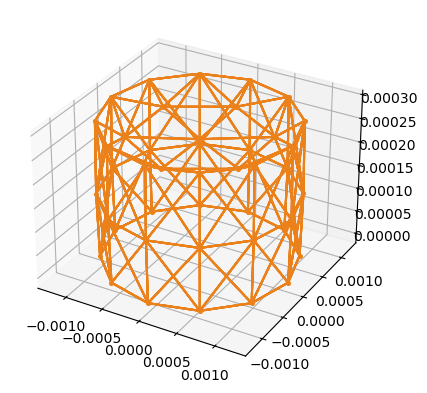

In [8]:
#%matplotlib notebook
# Plot the complex using matplotlib
HC.plot_complex()

## Plot data


In [9]:
HC.V.print_out()

Vertex cache of size: 43:
Vertex: (-9.096202269630409572e-08, 0.0012051560936841447717, 0.00028830743032509885245)
Connections: (-2.531365321089354106e-07, 0.0012160217468215018403, 0.00013574667847764529976) (-0.00060251127132390586426, 0.0010437924389130394621, 0.000288259784598111358) (-0.0006077698717943166207, 0.00105327046314075055, 0.00013576365892510146508) (0.0006085177233853181349, 0.0010528257556439065706, 0.00013577170705981582056) (5.6030521097338070585e-11, 0.00086681510403851481144, 0.00025505846631413798092) (0.00060269827113106925555, 0.0010436826985974012292, 0.00028826147528887615257) 
Vertex: (0.0010436804307658008954, 0.00060256795344460026077, 0.00028832634258030661981)
Connections: (0.001205173656405654668, -9.5826458826204896586e-08, 0.0002882916367299871896) (0.0006085177233853181349, 0.0010528257556439065706, 0.00013577170705981582056) (0.00075068421390949424256, 0.00043340766302019348824, 0.0002550584768164355916) (0.0012160512472330853122, -2.565959650183767

In [ ]:
# Plot
if 0:
    HC.dim = 3  # In case this changed for polyscope surface
    fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                               line_color=db,
                                               complex_color_f=lb,
                                               complex_color_e=db
                                               )

    #fig, axes, fig_s, axes_s
    #plot_polyscope(HC)
    #axes.scatter(data_xyz[:, 0], data_xyz[:, 1], data_xyz[:, 2])
    #axes.scatter(0.0, 0.0, -R * np.sin(theta_p))
    axes.set_zlim((0, 1e-3)) 
    #axes.scatter(0.0, 0.0, -(R-R * np.sin(theta_p)))

#for v in HC.V:
if 0:
    max_d = 0.0
    min_d = 0.0
    for v in data_xyz:
        #print(f'R = {R}')
        N_f0 = v - np.array([0.0, 0.0, -(R - R * np.sin(theta_p))])
        N_f0 = v - np.array([0.0, 0.0, - R * np.sin(theta_p)])
        d = np.linalg.norm(N_f0)
        #print(f' np.linalg.norm(N_f0) = {d}')
        max_d = max([(R - d), max_d])
        min_d = min([(R - d), min_d])
print(f'gamma = {gamma}')
plot_polyscope(HC)
plt.show()